<a href="https://colab.research.google.com/github/giakomorssi/Deloitte_Project/blob/main/03_FraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Change Colab runtime to GPU
import os
os.environ['COLAB_TPU_ADDR'] = ''
os.environ['COLAB_GPU_ALLOC'] = '1'
os.environ['COLAB_GPU'] = '1'
print("Runtime switched to GPU")

import tensorflow as tf

if not tf.test.gpu_device_name():
    print('GPU device not found')
else:
    print('GPU device found:', tf.test.gpu_device_name())

# This code sets the runtime to use the GPU if available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

pd.set_option('display.max_columns', None)

Mounted at /content/drive
Runtime switched to GPU
GPU device not found
Please install GPU version of TF


In [3]:
df = pd.read_csv('/content/drive/MyDrive/University/Deloitte/SupplyChainDataset.csv', encoding = 'latin-1')

# Cleaning

In [4]:
# Remove Na and Empty Columns

df.drop(['Product Description', 'Order Zipcode', 'Order Profit Per Order', 'Customer Email', 'Customer Password'], axis = 1, inplace = True) 
df.dropna(inplace = True) #remove 1 missing value

## Create the Category Column

1. **COMPLETE:** The order or transaction has been successfully fulfilled and completed.
2. **PENDING**: The order or transaction is still in progress and has not yet been completed.
3. **CLOSED**: The order or transaction has been closed or terminated for some reason, such as a return or cancellation.
4. **PENDING_PAYMENT**: The order or transaction is awaiting payment before it can be processed.
5. **CANCELED**: The order or transaction has been canceled by the customer or the seller for some reason.
6. **PROCESSING**: The order or transaction is being processed by the seller or merchant.
7. **SUSPECTED_FRAUD**: The order or transaction is under review due to suspected fraudulent activity.
8. **ON_HOLD**: The order or transaction has been placed on hold for some reason, such as a delay in shipping or a credit hold.
9. **PAYMENT_REVIEW**: The payment for the order or transaction is under review by the payment processor or financial institution.

In [5]:
# Regular -> Complete, Pending, Pending_Payment, Processing
# Suspected -> Closed, Canceled, On_Hold, Payment_Review
# Fraud -> Suspected_Fraud

# define dictionaries to map status values to categories
regular_dict = {'COMPLETE': 'Regular', 'PENDING': 'Regular', 'PENDING_PAYMENT': 'Regular', 'PROCESSING': 'Regular'}
suspected_dict = {'CLOSED': 'Suspected', 'CANCELED': 'Suspected', 'ON_HOLD': 'Suspected', 'PAYMENT_REVIEW': 'Suspected'}
fraud_dict = {'SUSPECTED_FRAUD': 'Fraud'}

# create a function to map status values to categories
def map_category(status):
    if status in regular_dict:
        return regular_dict[status]
    elif status in suspected_dict:
        return suspected_dict[status]
    elif status in fraud_dict:
        return fraud_dict[status]
    else:
        return 'Unknown'

# apply the function to the 'status' column to create a new 'category' column
df['Category'] = df['Order Status'].apply(map_category)

print('Regular: ', len([x for x in df['Category'] if x == 'Regular']), '\n')
print('Suspected: ', len([x for x in df['Category'] if x == 'Suspected']), '\n')
print('Fraud: ', len([x for x in df['Category'] if x == 'Fraud']))

Regular:  141442 

Suspected:  35004 

Fraud:  4062


## Encoding

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Type
df['Type'] = le.fit_transform(df['Type'])

# Delivery Status
df['Delivery Status'] = le.fit_transform(df['Delivery Status'])

# Customer Segment
df['Customer Segment'] = le.fit_transform(df['Customer Segment'])

# Order Status
df['Order Status'] = le.fit_transform(df['Order Status'])

# Shipping Mode
df['Shipping Mode'] = le.fit_transform(df['Shipping Mode'])

# Category
df['Category'] = le.fit_transform(df['Category'])

# EDA

In [7]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

temp = df["Category"].value_counts()
df1 = pd.DataFrame({'Category': temp.index,'values': temp.values})

# Define a list of colors for the bars
colors = ['red', 'blue', 'green']

traces = []
for i, category in enumerate(df1['Category']):
    if category == 1:
        name = "Regular"
    elif category == 0:
        name = "Suspected"
    else:
        name = "Fraud"
    trace = go.Bar(
        x=[name], y=[df1.loc[i, 'values']],
        name=name,
        marker=dict(color=colors[i]),
        text=[df1.loc[i, 'values']],
        legendgroup="group"
    )
    traces.append(trace)

layout = dict(title='Credit Card Fraud Class - data unbalance',
              xaxis=dict(title='Class', showticklabels=True), 
              yaxis=dict(title='Number of transactions'),
              hovermode='closest', width=600,
              showlegend=True
             )
fig = go.Figure(data=traces, layout=layout)
iplot(fig, filename='class')

In [8]:
# Correlation Plot

df.corr().style.background_gradient(cmap='coolwarm').set_properties(**{'max_width': '50px'})

<ipython-input-8-4c118ae839c4>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

/usr/local/lib/python3.9/dist-packages/pandas/io/formats/style.py:3931: RuntimeWarning:

All-NaN slice encountered

/usr/local/lib/python3.9/dist-packages/pandas/io/formats/style.py:3932: RuntimeWarning:

All-NaN slice encountered



,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Customer Id,Customer Segment,Customer Zipcode,Department Id,Latitude,Longitude,Order Customer Id,Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Status,Product Card Id,Product Category Id,Product Price,Product Status,Shipping Mode,Category
Type,1.000000,0.004859,0.000688,-0.003565,0.001348,0.045591,-0.061530,-0.000041,0.000949,-0.000617,-0.005861,-0.000837,-0.004187,0.007726,0.000949,0.005641,0.000325,-0.001662,-0.001468,0.005809,-0.000211,-0.002023,0.002671,0.000950,0.001348,0.806074,0.000325,-0.000041,-0.000211,nan,0.000032,-0.506806
Days for shipping (real),0.004859,1.000000,0.515884,-0.005108,0.001760,0.027065,0.401418,-0.000316,0.003460,0.002060,0.000122,-0.001634,-0.004068,0.003891,0.003460,-0.001690,-0.000835,0.002248,0.001483,-0.001750,0.002196,-0.004645,-0.000820,0.001968,0.001760,0.008493,-0.000835,-0.000316,0.002196,nan,0.515662,-0.005341
Days for shipment (scheduled),0.000688,0.515884,1.000000,-0.000210,0.006421,-0.172330,-0.369343,-0.000383,0.000877,-0.000084,-0.003026,-0.000227,-0.005318,0.003676,0.000877,-0.001891,-0.000445,0.002906,0.000091,-0.001861,0.006890,-0.001834,-0.002919,0.006306,0.006421,0.003756,-0.000445,-0.000383,0.006890,nan,0.919295,0.000812
Benefit per order,-0.003565,-0.005108,-0.000210,1.000000,0.133435,0.000903,-0.003729,0.031826,0.009286,-0.002507,0.002229,0.031455,0.000320,-0.002523,0.009286,0.013662,0.033102,0.064744,-0.018634,0.013504,0.103401,0.823691,0.015722,0.131769,0.133435,-0.002975,0.033102,0.031826,0.103401,nan,-0.002443,0.002527
Sales per customer,0.001348,0.001760,0.006421,0.133435,1.000000,-0.001378,-0.003781,0.225149,0.060084,-0.005117,-0.001331,0.232448,-0.000232,0.001471,0.060084,0.078926,0.236311,0.498727,-0.119480,0.078106,0.781762,-0.001462,0.105458,0.989744,1.000000,0.002810,0.236311,0.225149,0.781762,nan,0.003528,0.000454
Delivery Status,0.045591,0.027065,-0.172330,0.000903,-0.001378,1.000000,-0.190505,-0.001456,-0.000004,-0.002878,0.001421,-0.000761,0.003219,0.002809,-0.000004,0.004629,-0.001377,-0.001049,-0.001241,0.004677,-0.000477,0.001457,-0.002670,-0.001423,-0.001378,0.000046,-0.001377,-0.001456,-0.000477,nan,-0.081307,-0.015559
Late_delivery_risk,-0.061530,0.401418,-0.369343,-0.003729,-0.003781,-0.190505,1.000000,0.001780,0.001512,0.001424,0.003166,0.001049,0.000700,-0.001953,0.001512,-0.001273,0.001513,-0.000739,0.000399,-0.001357,-0.002160,-0.002319,-0.000148,-0.003554,-0.003781,-0.004115,0.001513,0.001780,-0.002160,nan,-0.401366,0.017364
Category Id,-0.000041,-0.000316,-0.000383,0.031826,0.225149,-0.001456,0.001780,1.000000,0.274391,0.000342,0.002846,0.889035,0.002172,-0.002193,0.274391,0.198302,0.991096,0.140142,0.000579,0.186611,0.461007,-0.001650,-0.302355,0.227429,0.225149,0.000740,0.991096,1.000000,0.461007,nan,0.000233,0.001703
Customer Id,0.000949,0.003460,0.000877,0.009286,0.060084,-0.000004,0.001512,0.274391,1.000000,0.003504,0.001959,0.136940,0.002321,-0.005006,1.000000,0.204622,0.227822,0.038427,0.001719,0.191625,0.110975,-0.000371,-0.091234,0.060862,0.060084,0.000884,0.227822,0.274391,0.110975,nan,0.000220,-0.005362
Customer Segment,-0.000617,0.002060,-0.000084,-0.002507,-0.005117,-0.002878,0.001424,0.000342,0.003504,1.000000,-0.004071,0.000620,-0.010386,0.000766,0.003504,-0.000333,-0.000250,-0.001378,0.001132,-0.000398,-0.002693,-0.001880,-0.002837,-0.004871,-0.005117,-0.003081,-0.000250,0.000342,-0.002693,nan,-0.001641,0.003731


## Prepare the Data

In [9]:
from sklearn.model_selection import train_test_split

df.drop(['Category Name', 'Customer City',
       'Customer Country', 'Customer Fname', 'Customer Id', 'Customer Lname',
       'Customer State',	'Customer Street', 'Department Name', 
       'Market', 'Order City', 'Order Country', 'Order Customer Id', 'Order Region',	
       'Order State', 'Product Image',	'Product Name',
       'shipping date (DateOrders)', 'order date (DateOrders)', 'Category Id', 'Customer Zipcode', 
       'Department Id', 'Latitude',	'Longitude', 'Order Id',	'Order Item Cardprod Id',
       'Order Item Id', 'Product Card Id', 'Product Category Id'], axis = 1, inplace = True)

In [10]:
from sklearn.model_selection import train_test_split  

X = df.drop(['Category'], axis=1) #Not scaled
y = df['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)

In [11]:
from sklearn.preprocessing import StandardScaler

s = StandardScaler()

X_train = s.fit_transform(X_train)
X_test = s.transform(X_test)

# PCA

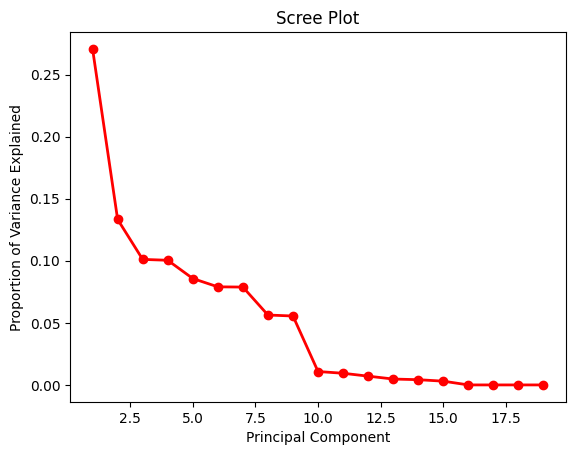


 Number of components to keep: 9


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Initialize a PCA object
pca = PCA()

# Fit the PCA object to the data
pca.fit(X_train)

# Create a scree plot
num_components = len(pca.explained_variance_ratio_)
plt.plot(np.arange(1, num_components+1), pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

# Determine the number of components to keep
variance_threshold = 0.95
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
num_components_to_keep = np.argmax(cumulative_variance_ratio >= variance_threshold) + 1

print(f'\n Number of components to keep: {num_components_to_keep}')

# Transform the data using the chosen number of components
pca = PCA(n_components=num_components_to_keep)
X_train_p = pca.fit_transform(X_train)
X_test_p = pca.transform(X_test)

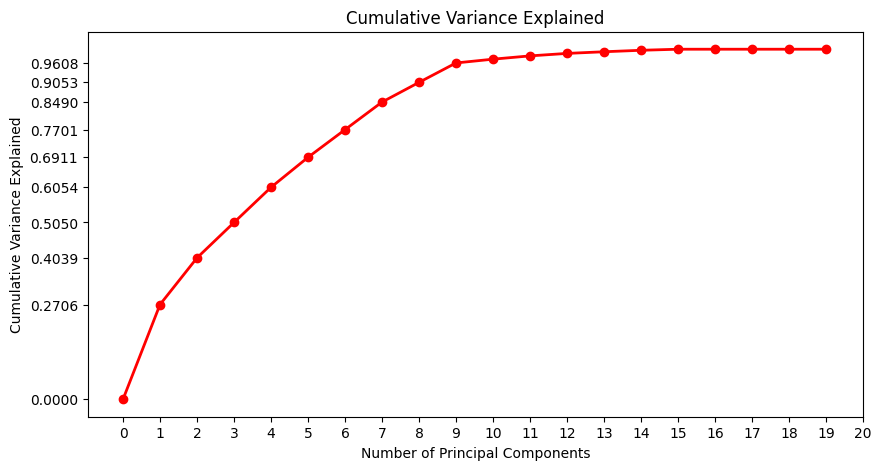

In [13]:
# Plot the cumulative variance explained

fig = plt.figure(figsize=(10, 5))

cum = np.insert(cumulative_variance_ratio, 0, 0)
ylab = np.insert(np.cumsum(pca.explained_variance_ratio_), 0, 0)

plt.plot(cum, 'ro-', linewidth=2)
plt.title('Cumulative Variance Explained')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.yticks(ylab)
plt.xticks(np.arange(0, 21))
plt.show()

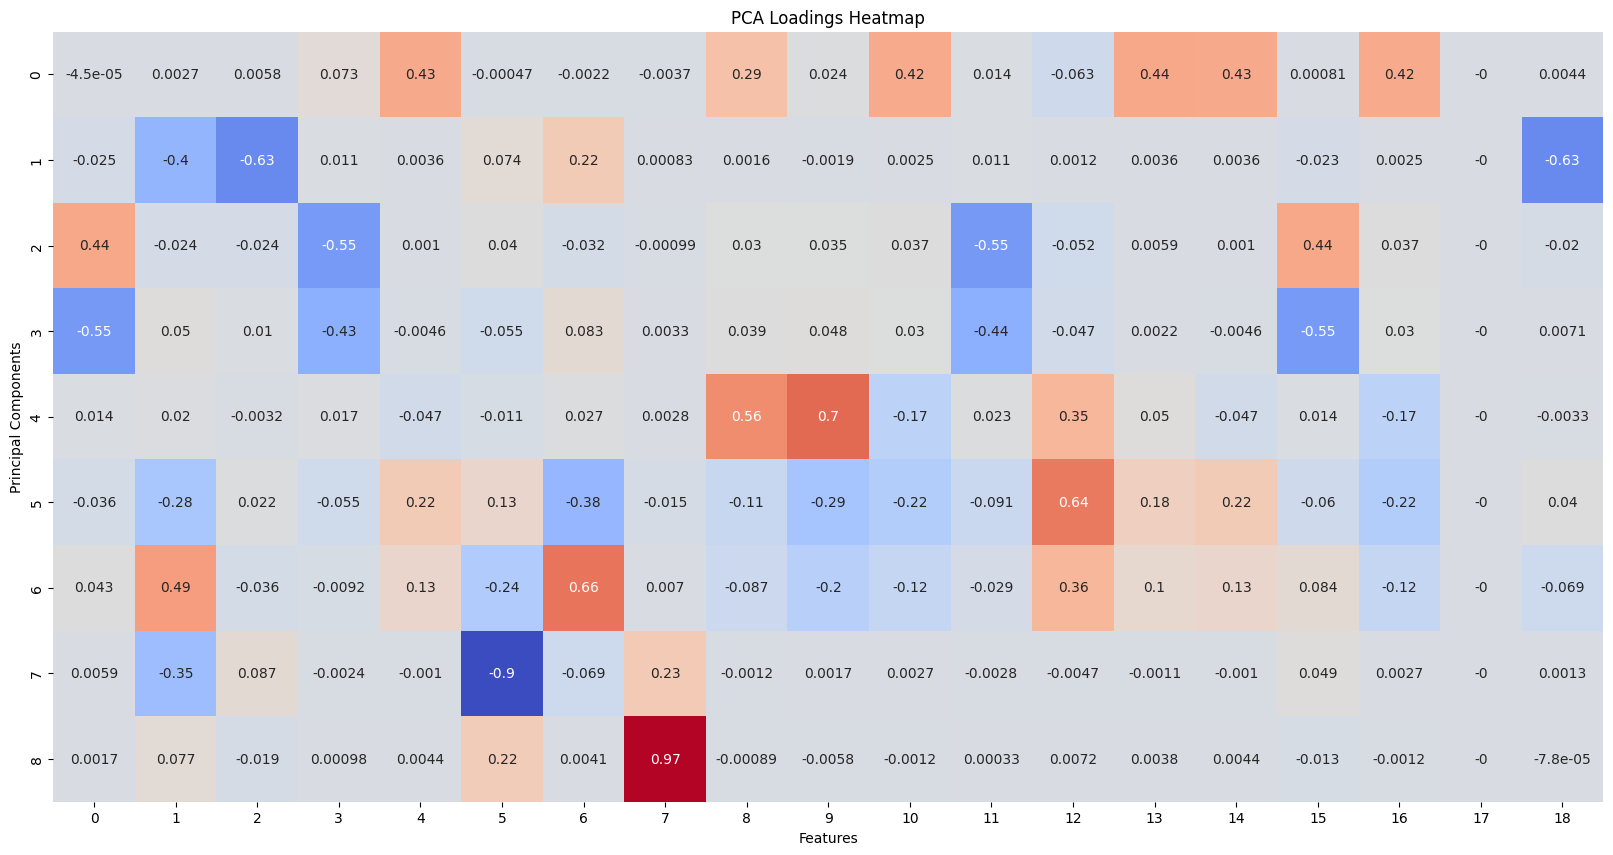

In [14]:
import seaborn as sns

# Heatmap loadings
fig = plt.figure(figsize=(20, 10))
sns.heatmap(pca.components_, cmap='coolwarm', annot=True, cbar=False)
plt.xlabel('Features')
plt.ylabel('Principal Components')
plt.title('PCA Loadings Heatmap')
plt.show()

In [15]:
# Get the principal components as vectors in the original feature space
pc_vectors = pca.components_

# Get the names of the original columns
column_names = X.columns

# Print the names of the columns chosen as principal components
num_pcs = pc_vectors.shape[0]
for i in range(num_pcs):
    pc_name = f'PC{i+1}'
    pc_loadings = pc_vectors[i]
    relevant_columns = column_names[np.abs(pc_loadings) >= 0.40]
    print(f'{pc_name}:\n {relevant_columns.tolist()}, \n {pc_loadings[np.abs(pc_loadings) >= 0.40]} \n ')

PC1:
 ['Sales per customer', 'Order Item Product Price', 'Sales', 'Order Item Total', 'Product Price'], 
 [0.42859661 0.41689971 0.43676789 0.42859661 0.41689971] 
 
PC2:
 ['Days for shipment (scheduled)', 'Shipping Mode'], 
 [-0.62654621 -0.62668936] 
 
PC3:
 ['Type', 'Benefit per order', 'Order Item Profit Ratio', 'Order Status'], 
 [ 0.43796011 -0.54835602 -0.55308289  0.43569911] 
 
PC4:
 ['Type', 'Benefit per order', 'Order Item Profit Ratio', 'Order Status'], 
 [-0.5511432  -0.43170836 -0.43687198 -0.54637753] 
 
PC5:
 ['Order Item Discount', 'Order Item Discount Rate'], 
 [0.56242466 0.7024975 ] 
 
PC6:
 ['Order Item Quantity'], 
 [0.63888949] 
 
PC7:
 ['Days for shipping (real)', 'Late_delivery_risk'], 
 [0.48709312 0.66076592] 
 
PC8:
 ['Delivery Status'], 
 [-0.89963508] 
 
PC9:
 ['Customer Segment'], 
 [0.97257384] 
 


# Models

In [16]:
import pandas as pd
import numpy as np
import pickle

# Split the dataset into features and target
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
y_train = np.ravel(y_train)

print(X_train.shape, y_train.shape)
print(type(X), type(y))

(144406, 19) (144406,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [17]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier

fraud = StackingClassifier(estimators=[('lr', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000, class_weight='balanced')),
                                      ('dt', DecisionTreeClassifier(max_depth=4))],
                                              final_estimator=DecisionTreeClassifier(max_depth=5))

fraud1 = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000, class_weight='balanced')

regular = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=4, subsample=0.8)

regular2 = SGDClassifier(loss='log_loss', penalty='elasticnet', alpha=0.0001, l1_ratio=1, max_iter=1000)

suspected = DecisionTreeClassifier(class_weight='balanced', max_depth= 4)

reg_sus = XGBClassifier(objective='multi:softmax', num_class=3, max_depth=4, subsample=0.8,
                    colsample_bytree=0.8, learning_rate=0.3)

## Voting2class1

In [18]:
from sklearn.ensemble import VotingClassifier

# Initialize the voting classifier with the base models
model = VotingClassifier(estimators=[('fraud', fraud1), ('reg_sus', reg_sus)], voting='soft')

model.fit(X_train, y_train)

with open('/content/drive/MyDrive/University/Deloitte/models/Voting2class1.pkl', 'wb') as file:
    pickle.dump(model, file)

KeyboardInterrupt: ignored

## Voting2class

In [ ]:
from sklearn.ensemble import VotingClassifier

# Initialize the voting classifier with the base models
model = VotingClassifier(estimators=[('fraud', fraud), ('reg_sus', reg_sus)], voting='hard')

model.fit(X_train, y_train)

with open('/content/drive/MyDrive/University/Deloitte/models/Voting2class.pkl', 'wb') as file:
    pickle.dump(model, file)

## BaggingLogistic

In [ ]:
from sklearn.ensemble import BaggingClassifier

model = BaggingClassifier(estimator=LogisticRegression(max_iter=1000, multi_class='multinomial'),
                  n_estimators=30)

model.fit(X_train, y_train)

with open('/content/drive/MyDrive/University/Deloitte/models/BaggingLogistic.pkl', 'wb') as file:
    pickle.dump(model, file)

# Try the model over 100 split

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, recall_score
import os
import pickle
import pandas as pd

# Standardize the data and split it into training and test sets
s = StandardScaler()

recall_scores = []
precision_scores = []
f1_scores = []
accuracy_scores = []
fraud_recall = []
suspected_recall = []
regular_recall = [] 
low = []
avg_conf_matrix = np.zeros((3, 3))

np.set_printoptions(precision=2)
#StackingXGB

with open('/content/drive/MyDrive/University/Deloitte/bests/Voting2class.pkl', 'rb') as f:
    model = pickle.load(f)

for i in range(1, 101):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)

  X_train = s.fit_transform(X_train)
  X_test = s.transform(X_test)

    # PCA
  pca = PCA()
  pca.fit(X_train)

  cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
  num_components_to_keep = np.argmax(cumulative_variance_ratio >= 0.95) + 1

  pca = PCA(n_components=num_components_to_keep)
  X_train = pca.fit_transform(X_train)
  X_test = pca.transform(X_test)

  y_pred = model.predict(X_test)

  conf_matrix = confusion_matrix(y_test, y_pred)

  recalls = []
  for j in range(conf_matrix.shape[0]):
      tp = conf_matrix[j,j]
      fn = np.sum(conf_matrix[j,:]) - tp
      recall = tp / (tp + fn)
      recalls.append(recall)

  recall_scores.append(recall_score(y_test, y_pred, average="macro"))
  fraud_recall.append(recalls[0])
  regular_recall.append(recalls[1])
  suspected_recall.append(recalls[2])

  conf_matrix = confusion_matrix(y_test, y_pred)
  avg_conf_matrix += conf_matrix

  if i % 10 == 0:
      print(f'Iteration: {i}')
      print(f'Fraud Recall {round(np.average(fraud_recall), 4)}, {round(np.std(fraud_recall), 4)}')
      print(f'Suspected Recall {round(np.average(suspected_recall), 4)}, {round(np.std(suspected_recall), 4)}')
      print(f'Regular Recall {round(np.average(regular_recall), 4)}, {round(np.std(regular_recall), 4)}')
      print(f'Total Recall {round(np.average(recall_scores), 4)}, {round(np.std(recall_scores), 4)} \n')

  if recalls[0] < 0.7:
    low.append(round(recalls[0], 4))
  
print(f'\n Fraud Recall: {round(np.average(fraud_recall), 4)}, std: {round(np.std(fraud_recall), 4)}, Under 0.7: {len(low)}, {low}\n Suspected Recall: {round(np.average(suspected_recall), 4)}, std: {round(np.std(suspected_recall), 4)}\n Regular Recall: {round(np.average(regular_recall), 4)}, std: {round(np.std(regular_recall), 4)}\n Total: {round(np.average(recall_scores), 4)}, std: {round(np.std(recall_scores), 4)}')

np.set_printoptions(precision=2)
avg_conf_matrix /= 100
print("\n Average Confusion Matrix:")
print(avg_conf_matrix)

print('\n', model)


[14:27:03] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

Iteration: 10
Fraud Recall 0.9246, 0.2005
Suspected Recall 0.7842, 0.0797
Regular Recall 0.951, 0.0515
Total Recall 0.8866, 0.1021 

Iteration: 20
Fraud Recall 0.956, 0.1455
Suspected Recall 0.7873, 0.0794
Regular Recall 0.9521, 0.0455
Total Recall 0.8985, 0.0783 

Iteration: 30
Fraud Recall 0.9558, 0.1298
Suspected Recall 0.7846, 0.0731
Regular Recall 0.9495, 0.0421
Total Recall 0.8967, 0.0704 

Iteration: 40
Fraud Recall 0.9319, 0.1449
Suspected Recall 0.7741, 0.0773
Regular Recall 0.939, 0.0519
Total Recall 0.8817, 0.08 

Iteration: 50
Fraud Recall 0.9398, 0.1326
Su

# Results

**Baseline Model**
```python
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000, class_weight='balanced')
```
```python
Fraud Recall: 0.9228, std: 0.1951
Average Confusion Matrix: [749 42 2]
```
```python
Fraud Recall: 0.9228, std: 0.1951
Average Confusion Matrix: [749 42 2]
```
```python
Fraud Recall: 0.9228, std: 0.1951
Average Confusion Matrix: [749 42 2]
```


**Best Fraud**

*Voting2class*
```python
VotingClassifier(estimators=[('fraud',
                              StackingClassifier(estimators=[('lr', LogisticRegression(class_weight='balanced', max_iter=2000, multi_class='multinomial')),
                                                             ('dt', DecisionTreeClassifier(max_depth=4))],
                                                              final_estimator=DecisionTreeClassifier(max_depth=5))),
                             ('reg_sus',
                              XGBClassifier(learning_rate=0.3, max_depth=4, n_estimators=100, num_class=3, objective='multi:softmax'))])
```
```python
Fraud Recall: 0.9228, std: 0.1951
Average Confusion Matrix: [749 42 2]
```

**Best Suspected**

*Voting2class1*
```python
VotingClassifier(estimators=[('fraud',
                              LogisticRegression(class_weight='balanced', max_iter=2000, multi_class='multinomial')),
                             ('reg_sus',
                              XGBClassifier(colsample_bytree=0.8,
                                            learning_rate=0.3, max_depth=4, n_estimators=100, num_class=3, objective='multi:softmax'))], 
                  voting='soft')
```
```python
Suspected Recall: 0.8843, std: 0.1285
Average Confusion Matrix: [24 787 6190]
```

**Best Regular**

*Bagging Logistic Model:*
```python
BaggingClassifier(estimator=LogisticRegression(max_iter=1000, multi_class='multinomial'),
                  n_estimators=30)
```
```python
Regular Recall: 0.9585, std: 0.0422
Average Confusion Matrix: [466  27115  708]
```

**Best Overall**
1. *Voting2class1* 

more balanced between the 3 recalls
```python
VotingClassifier(estimators=[('fraud',
                              LogisticRegression(class_weight='balanced', max_iter=2000, multi_class='multinomial')),
                             ('reg_sus',
                              XGBClassifier(colsample_bytree=0.8,
                                            learning_rate=0.3, max_depth=4, n_estimators=100, num_class=3, objective='multi:softmax'))], 
                  voting='soft')
```
```python
Fraud Recall: 0.8637, std: 0.2231
```
```python
Suspected Recall: 0.8913, std: 0.1258
```
```python
Regular Recall: 0.9366, std: 0.0675
```
```python
Total Recall: 0.8972, std: 0.1322
```
```python
 Average Confusion Matrix:
[[701  87  24]
 [235  26500  1560]
 [25  736  6240]]
```

2. *Voting2class* 

Better on Regular and Fraud, less in Suspected
```python
VotingClassifier(estimators=[('fraud', StackingClassifier(estimators=[('lr', LogisticRegression(class_weight='balanced', max_iter=2000, multi_class='multinomial')), 
                                                                      ('dt', DecisionTreeClassifier(max_depth=4))], 
                                                          final_estimator=DecisionTreeClassifier(max_depth=5))),
                             ('reg_sus',
                              XGBClassifier(learning_rate=0.3, max_depth=4 n_estimators=100, num_class=3, objective='multi:softmax'))])
```

```python
Fraud Recall: 0.9387, std: 0.1318	
```
```python
Suspected Recall: 0.7848, std: 0.0763 
```
```python
Regular Recall: 0.9541, std: 0.0395
```
```python
Total Recall: 0.8925, std: 0.0708
```
```python
 Average Confusion Matrix:
[[762  5  0]
 [625  27000  674]
 [5  1500  5490]]
 ```

# Visualization